![](figures/Logo.PNG)

Please click the <span>&#x23E9;</span> button to run all cells before you start working on the notebook ...

## In this term assignment, you will

* work with two catchments and objective functions
* use and discuss Morris method for parameter screening
* use and discuss Sobol variance indices for parameter ranking
* discuss the model fit
* _additionally: write you own objective function_

<div style="background:#fac7c3; padding: 1%; border:1mm solid Crimson; color:black">
    <p>The submission deadline is <b>28.02.25</b>.</p>
    You will analyse two different catchments each, therefore please submit one notebook per person. You are of course allowed to discuss your results.
</div>

## How to Submit the Assignment

After you have finished working on the report we would like you to submit as follows. In the web interface of Jupyter Notebook or Lab...
1. Export the notebook as HTML by clicking `File > Save and Export Notebook As > HTML`
2. Mail both the HTML export, as well as the `.ipynb` file to David ([david.strahl@uni-potsdam.de](mailto:david.strahl@uni-potsdam.de))

Please open the HTML file in your browser and make sure that it displays your last results as intended before submission.

If you use another coding environment like PyCharm or VSCode it is likely easier to open the notebook once in the web interface to export it.

---

## Install Joblib to Parallelize HBV Runs

To improve the efficiency of expensive HBV model runs and cache results between sessions in your Jupyter Notebook, you need to install the `joblib` Python package. This package allows you to parallelize computations and persist intermediate results. Of course it is nice to have a cup of coffee (or tea) while you wait for the notebook too execute, but this is only fun ever so often.

To install `joblib`, please follow these steps. We can help you in the tutorials on the 30.01.25 and 06.02.25.

First, activate the conda environment where you usually start Jupyter:

```bash
conda activate <your-environment-name>
```

You can know install `joblib` using `pip`:

```bash
pip install joblib
```
---

In [1]:
import os
import sys
import re
sys.path.append("src")
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from joblib import Parallel, Memory, delayed
from src import HBV, sampling, EET, VBSA, util, plot_functions

plt.style.use('default')
plt.cm.jet = lambda _: ["#e6194B", "#3cb44b", "#4363d8", "#f58231", "#aaffc3", "#42d4f4", "#a9a9a9", "#ffe119", "#f032e6", "#fabed4", "#469990", "#9A6324", "#dcbeff"]

memory = Memory("./cache", verbose=False)

In [2]:
# more functions we need in the background

CATCHMENT_NAMES = {
    '02479560': "Escatawpa River, Mississippi",
    '01022500': 'Narraguagus River, Maine',
    '02298608': "Myakka River, Florida",
    '12358500': 'Middle Fork Flathead River, Montana',
    '06614800': "Michigan River, Colorado",
    '06280300': "Shoshone River, Wyoming"
}

def exclude_spinup(of, spinup=0.1):
    """
    Decorator to exclude the spinup period from the objective function calculation.

    Parameters
    ----------
    of : function
        Objective function to be wrapped. Must have the signature of (Q_obs, Q_sim)
    spinup: float or int
        Fraction of the spinup period to be excluded from the objective function calculation. If an integer is given, the first n values are excluded. Default is 0.1.
    """
    from functools import wraps
    @wraps(of)
    def _exclude_spinup_wrapper(Q_obs, Q_sim):
        assert Q_obs.shape == Q_sim.shape
        index = int(spinup) if spinup < 1 else int(spinup * len(Q_obs))
        return of(Q_obs[index:], Q_sim[index:])
    return _exclude_spinup_wrapper


def get_catchment_files(gauge_ids):

    assert type(gauge_ids) is list and len(gauge_ids) >= 2, "Please enter your two catchment IDs"

    catchment_files = []
    catchment_names = []
    for i, gauge_id in enumerate(gauge_ids):
        assert type(gauge_id) is str or type(gauge_id) is int, f"Unknown gauge ID: {gauge_id}"
        if type(gauge_id) is int:
            gauge_ids[i] = str(gauge_id).zfill(8)
        assert os.path.exists(f"./data/{gauge_id}.txt"), f"Cannot find file for ID: {gauge_id}"
        catchment_files.append(f"./data/{gauge_id}.txt")
        catchment_names.append(CATCHMENT_NAMES[gauge_id])
    return catchment_files, catchment_names


def check_objective_functions(objective_functions):

    assert len(objective_functions) == 2, "Please select two objective functions"

    for j, of in enumerate(objective_functions):
        if type(of) == str:
            assert of.lower() in globals(), f"Objective function '{of}' not found. Have you mispelled it?"
            objective_functions[j] = globals()[of.lower()]
        if callable(of):
            assert len(of.__code__.co_varnames) == 3, "Objective function must have the signature 'def objective(Q_obs, Q_sim)'"

    print("You selected the objective functions " + ", ".join([of.__name__.upper() for of in objective_functions]))

    # your_objective = globals()["your_objective"]
    if your_objective in objective_functions:
        print("Cool! You chose to implement your own objective function.")
        Q1, Q2 = np.random.normal(size=(2, 100))
        assert np.isscalar(your_objective(Q1, Q1)), "Your objective function should return a number."
        assert your_objective(Q1, Q1) < your_objective(Q1, Q2), "Your objective function should return smaller numbers for better fits."

    return objective_functions


def check_screened_parameters(params):

    assert len(params) <=  13, "You seem to have selected a parameter twice"
    assert len(params) >=  4,  "Please select at least four parameters for screening"

    for i, param in enumerate(params):
        if type(param) is str:
            assert param.upper() in param_names, f"{param} is not a valid parameter name"
            params[i] = param.upper()
        if type(param) is int:
            assert 0 <= param < 13, "The parameter index must positive and below 13"
            param[i] = param_names[param]

    params = sorted(params, key=lambda param: param_names.tolist().index(param))
    print(f"You selected {len(params)} parameters for ranking: {', '.join(params)}")
    return params


@memory.cache(ignore=["data", "ofuns", "n_cpu_cores"])
def run_hbv_and_evaluate(data, ofuns, params, n_cpu_cores=-1):
    """
    Run the HBV model on a given dataset and parameter set and evaluate the model performance using the given objective functions.

    Parameters
    ----------
    data: pd.DataFrame or list of pd.DataFrame
        DataFrame containing the columns "P", "T", "PET" and "Q_obs".
        The columns "P" and "T" are precipitation and temperature, respectively. "PET" is the potential evapotranspiration and "Q_obs" is the observed discharge.
    ofuns: function or list of functions
        Objective function to evaluate the model performance. Must have the signature of (Q_obs, Q_sim).
    params: np.array of shape (n_params,) or list of np.array
        Array containing the HBV parameters in the following order: Ts, CFMAX, CFR, CWH, BETA, LP, FC, PERC, K0, K1, K2, UZL, MAXBAS.
    n_cpu_cores: int
        Number of CPU cores for parallelization (default all).
    """

    # convert dataframes and objective functions to list if not already the case
    data    = list(data) if type(data) is not list else data
    n_data  = len(data)
    ofuns   = list(ofuns) if type(ofuns) is not list else ofuns
    n_ofuns = len(ofuns)

    # shape of the parameter array
    params   = np.atleast_2d(params)
    n_params = params.shape[0]
    shape    = (n_data, n_ofuns, n_params)

    # atomic wrapper for one HBV run
    def evaluate_single(i, j, k):
        Q_obs = data[i]["Q_obs"]
        Q_sim = run_hbv(data[i], params[k])
        return ofuns[j](Q_obs, Q_sim)

    # run HBV fully parallelized
    print(f"running HBV {np.prod(shape)} times, this may take a while...")
    objectives = Parallel(n_jobs=-1 if n_cpu_cores=="all" else n_cpu_cores)(delayed(evaluate_single)(i, j, k) for i, j, k in np.ndindex(shape))
    return np.array(objectives).reshape(shape).squeeze()

In [3]:
#### LOAD CATCHMENT DATA ####

def load_catchment_data(file, startDate="2010", endDate="2015"):
    """
    Load catchment data from a file and subset it to a given date range.
    The file must have the columns "YR", "MNTH", "DY", "PRCP", "TAIR", "PET" and "OBS_RUN".
    """
    data = pd.read_csv(file, sep=r"\s+")
    # combine columns to create a datetime column
    data['DATE'] = pd.to_datetime(data[['YR', 'MNTH', 'DY']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')
    # set the new column as the index
    data = data.set_index('DATE')
    # keep only relevant variables
    data = data[["PRCP", "TAIR", "PET", "SWE", "OBS_RUN"]]
    # rename the columns
    data.columns = ["P", "T", "PET", "SWE", "Q_obs"]
    # subset range
    data = data.loc[(data.index >= startDate) & (data.index <= endDate)]
    data.file = file
    return data


#### RUN HBV MODEL ####

def run_hbv(data, params):
    """
    Run the HBV model on a given dataset and parameter set.

    Parameters
    ----------
    data: pd.DataFrame
        DataFrame containing the columns "P", "T", "PET" and "Q_obs". The columns "P" and "T" are precipitation and temperature, respectively. "PET" is the potential evapotranspiration and "Q_obs" is the observed discharge.
    params: np.array of shape (13,)
        Array containing the HBV parameters in the following order: Ts, CFMAX, CFR, CWH, BETA, LP, FC, PERC, K0, K1, K2, UZL, MAXBAS
    """
    # check that there is the correct number of parameters
    assert params.shape == (13,)
    # convert PRCP, TAIR and PET to numpy arrays if necessary
    P, T, PET = data[["P", "T", "PET"]].T.to_numpy()
    # run HBV snow and rainfall-runoff routine
    P, _, _ = HBV.snow_routine(params[:4], T, P)
    Q, _, _ = HBV.hbv_sim(params[4:], P, PET, Case=2, ini=np.zeros(3))
    return Q

#### PLOTTING FUNCTIONS ####

def plot_hydrograph(data):
    plt.plot(data.index, data["Q_obs"], color="black", label="Observed")
    plt.xlabel("Date")
    plt.ylabel("Runoff [mm/day]")
    plt.sca(plt.twinx())
    plt.gca().invert_yaxis()
    plt.fill_between(data.index, 0, data["SWE"]/data["SWE"].max()*data["P"].max(), color="gray", alpha=0.5, label="Snow Volume")
    plt.bar(data.index, data["P"], label="Precipitation")
    plt.ylim([2*plt.ylim()[0], 0])
    plt.ylabel("Precipitation [mm/day]")

def plot_flow_duration_curve(Q, **kwargs):
    Q = np.sort(Q)[::-1]
    P = np.arange(1, len(Q) + 1) / (len(Q) + 1)
    plt.plot(P, Q, **kwargs)
    plt.semilogy()
    plt.ylabel("Runoff [mm/day]")
    plt.xlabel("Exceedance Probability")
    plt.gca().xaxis.set_major_formatter(lambda x, i: f"{x:.0%}")

#### PARAMETER RANGES ####

param_names = np.array(["TS"  , "CFMAX", "CFR", "CWH", "BETA", "LP", "FC", "PERC", "K0", "K1", "K2" , "UZL", "MAXBAS"])
lower       = np.array([-2.5  , 0.5    , 0    , 0    , 0     , 0.3 , 50  , 0     , 0.05, 0.01, 0.001, 0    , 1])
upper       = np.array([2.5   , 5      , 0.1  , 0.2  , 6     , 5   , 700 , 60    , 0.99, 0.8 , 0.15 , 250  , 3])
ranges      = np.stack([lower, upper], axis=1)
n_params    = len(param_names)

---
## 1 Loading the Catchment Data

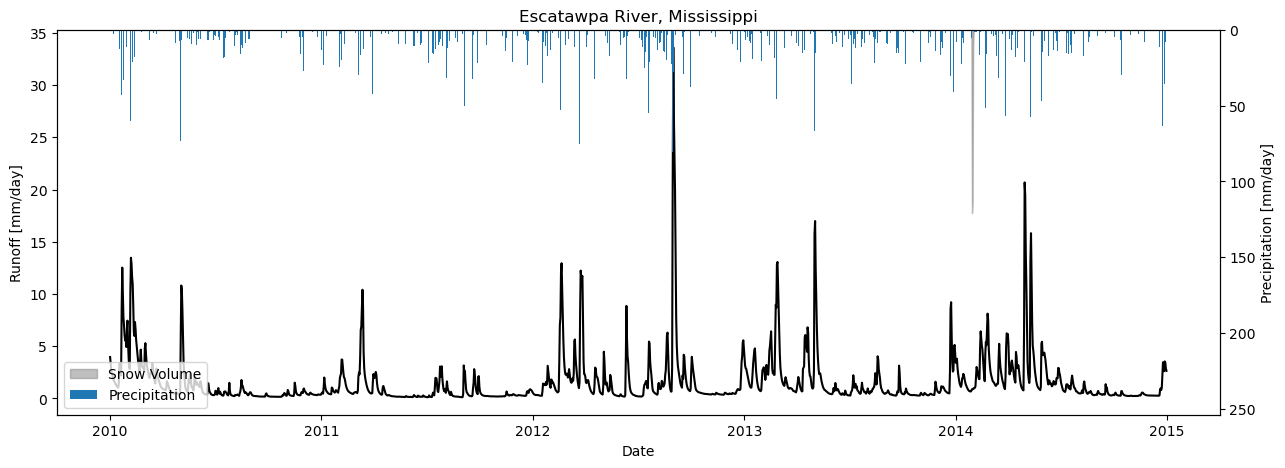

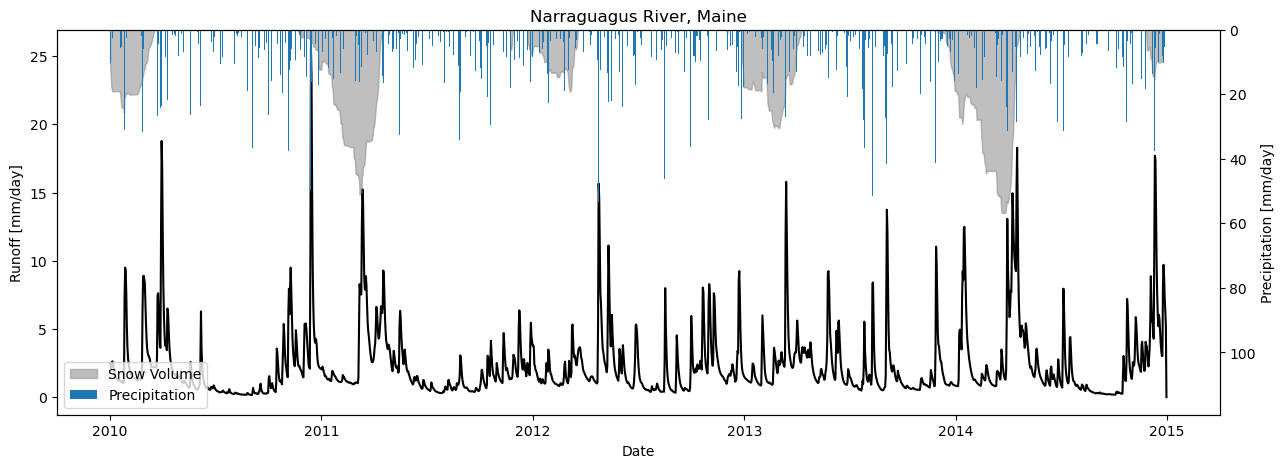

In [12]:
catchment_files, catchment_names = get_catchment_files(["02479560", "01022500"]) # TODO: write your catchment ids here
dfs = [load_catchment_data(file) for file in catchment_files]

# plot the hydrographs of the catchments
for name, df in zip(catchment_names, dfs):
    plt.figure(figsize=(15, 5))
    plot_hydrograph(df)
    plt.title(name)
    plt.legend()
    plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Familiarize Yourself with the Catchments</h4>
    <p>Each of you has been assigned two catchments at random. Above you see their hydrographs for the years 2010-2015. Familiarize yourself with the behavior of the two catchments. We would suggest that you find out where your catchment is located online.</p>
    <p>Don't worry, you will not be graded on your understanding of hydrology, but seeing your thought process may help us to follow your reasoning in the later analysis.</p>
</div>

_DOUBLE CLICK TO ANSWER HERE_

---
## 2 Defining Objective Functions

In [13]:
#### OBJECTIVE FUNCTIONS ####

@exclude_spinup
def absbias(Q_obs, Q_sim):
    """
    Calculate the absolute bias between observed and simulated discharge.
    """
    return np.abs(np.mean(Q_sim - Q_obs))

@exclude_spinup
def rmse(Q_obs, Q_sim):
    """
    Calculate the root mean squared error between observed and simulated discharge.
    """
    return np.mean((Q_sim - Q_obs)**2)**0.5

@exclude_spinup
def one_minus_nse(Q_obs, Q_sim):
    """
    Calculate the Nash-Sutcliffe efficiency between observed and simulated discharge.
    """
    return np.sum((Q_obs - Q_sim)**2)/np.sum((Q_obs - np.mean(Q_obs))**2)

@exclude_spinup
def one_minus_kge(Q_obs, Q_sim):
    return ((np.corrcoef(Q_obs, Q_sim)[0, 1] - 1)**2 + (np.std(Q_sim)/np.std(Q_obs) - 1)**2 + (np.mean(Q_sim)/np.mean(Q_obs) - 1)**2)**0.5

@exclude_spinup
def your_objective(Q_obs, Q_sim):
    pass # TODO: remove and implement your own objective function

#### SELECTING OBJECTIVE FUNCTIONS ####

OBJECTIVE_FUNCTIONS = [rmse, one_minus_kge] # TODO: choose two objective functions out of (absbias, rmse, one_minus_nse, one_minus_kge, your_objective)
OBJECTIVE_FUNCTIONS = check_objective_functions(OBJECTIVE_FUNCTIONS)

You selected the objective functions RMSE, ONE_MINUS_KGE


<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task I: Objective Functions</h4>
    <p>We would like you to choose two objective functions out of the ones above. You will later compare these objective functions and discuss their differences and similarities. You select the objective functions by writing their names in the empty list <code>[]</code> above. For instance, if you would like to use the absolute bias and the RMSE, you would change the list to <code>[absbias, rmse]</code><p>
    Please also discuss the following points:
    <ol>
        <li>What was your motivation between choosing these two objective functions?</li>
        <li>What are differences between the objective functions and why are these differences important?</li>
    </ol>
    <p>For some extra points you may want to implement your own objective function in the method <code>your_objective(Q_obs, Q_sim)</code>. This task is entirely optional, you can only gain points. The two arguments are the observed and simulated timeseries of runoff, respectively. You can use one from the lecture series that is not given here or you can think of one yourself. Please make sure that better fits results in lower values of your objective function. The decorator <code>@exclude_spinup</code> automatically removes the first 10% of the data so that the model can settle. You don't need to remove a spinup fraction yourself. If you don't feel comfortable enough with programming yet, just choose two of the implemented functions above.</p>
</div>

---
## 3 Parameter Screening Using Morris Method

As you have discussed in the lecture series, the first step to the model evulation process is often a preliminary screening of influential parameters. Here, we will do this using Morris' method of Elementary Effects.

Firstly, we generate `r` corkscrew trajectories in parameter space and run HBV for each paramter combination. Secondly, we perform the elementary effects analysis. You will see four plots, one for each catchment and objective function. Based on this analysis, we ask you to select a set of parameters that seem to be influential. Finally, you will take a look at the convergence behavior of the elementary effects for increasing numbers of trajectories in parameter space.

<div style="background:#fac7c3; padding: 1%; border:1mm solid Crimson; color:black">
    <h4><span>&#9888 </span>Parallelization and Caching</h4>
    <p>It may take some time to run the HBV model this often, so we have parallelized the code to use all CPU cores. We would suggest that you connect your laptop to the power supply to prevent unnecessary overheating. If it takes too long, you can try reducing the number of corkscrew trajectories or CPU cores by changing the parameters <code>r</code> and <code>n_cpu_cores</code>.</p>
    <p>We want you to be able to work on the notebook at different points in time without having to wait for the HBV execution. Therefore, the HBV runs are cached (permanently stored) so that they only need to be calculated once. If you changed the objective functions or the parameters for screening you can simply delete the <code>cache</code> folder that sits next to the notebook file to rerun HBV.</p>
</div>

### 3.1 Sampling and Model Evaluation



In [14]:
r = 500 # number of corkscrew trajectories in parameter space
L = 100 # subdivisions of the parameter space

# calculate the Morris samples
np.random.seed(42)
samples_morris = sampling.Morris_sampling(r, lower.tolist(), upper.tolist(), L)

# evaluate HBV for each sample and both datasets and objective functinos in one call
objectives_morris = run_hbv_and_evaluate(dfs, OBJECTIVE_FUNCTIONS, samples_morris, n_cpu_cores="all")

running HBV 28000 times, this may take a while...


### 3.2 Elementary Effects Analysis

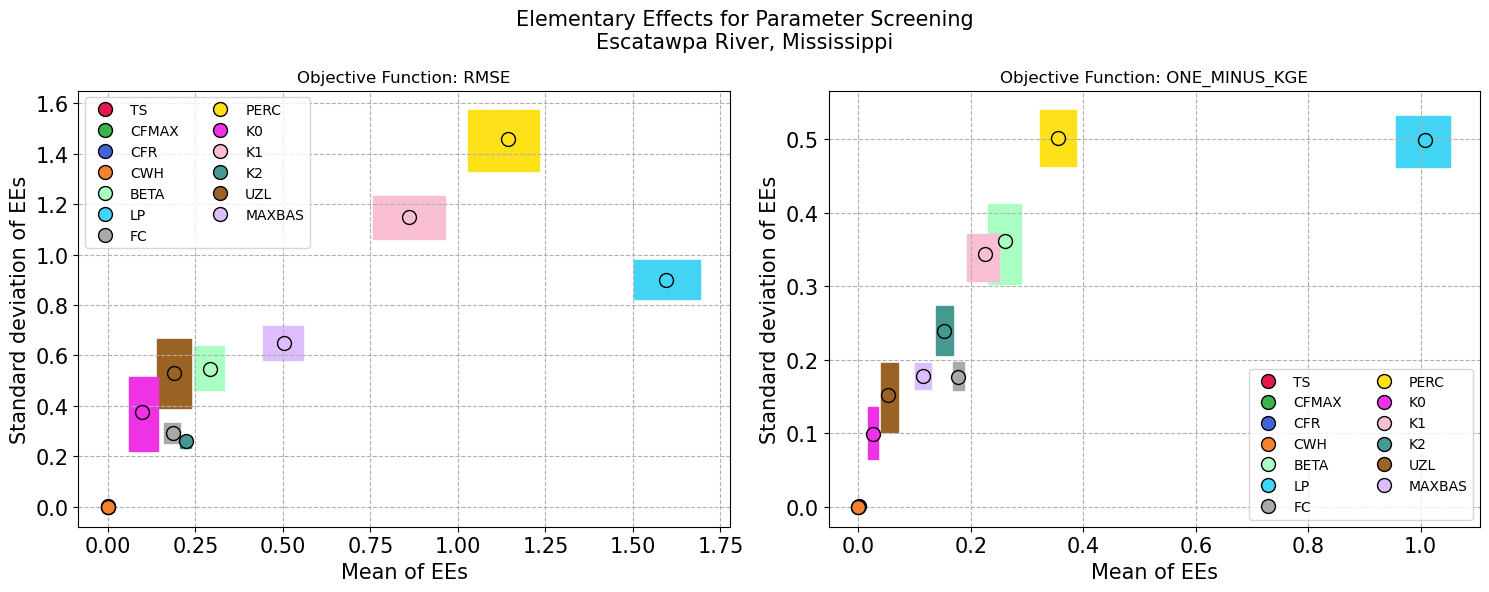

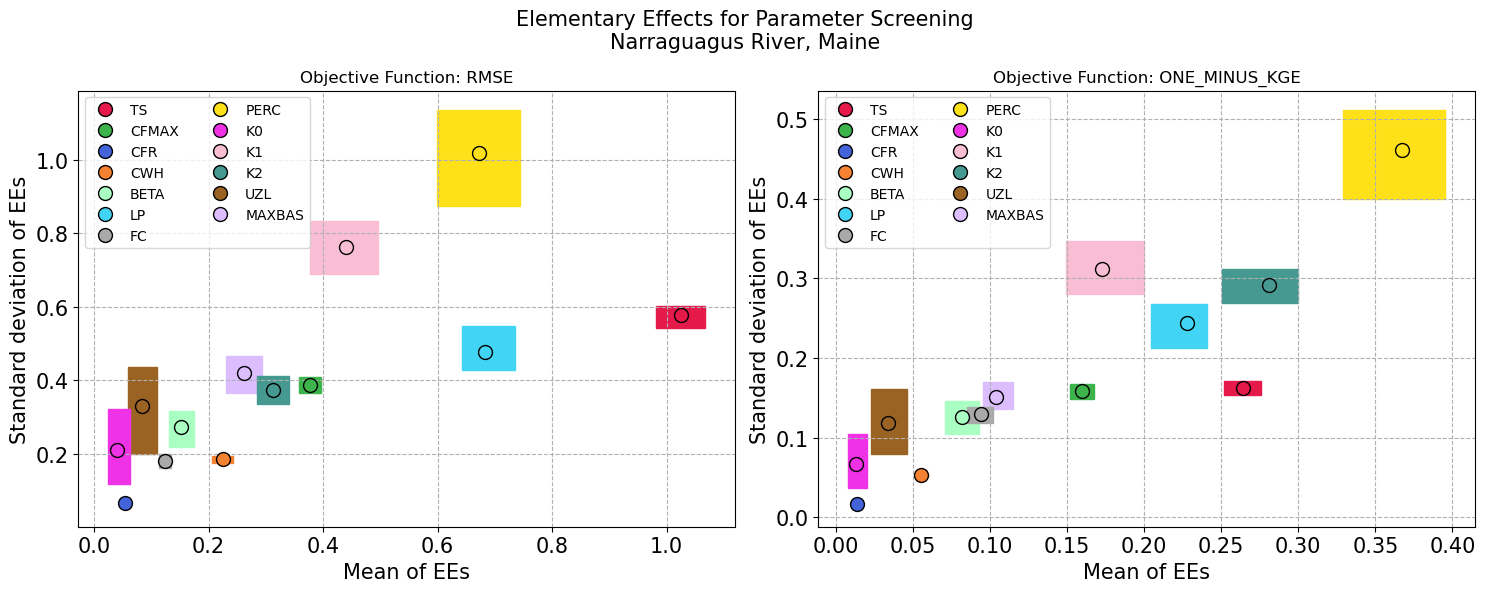

In [15]:
for i, df in enumerate(dfs):

    fig, axs = plt.subplots(1, len(OBJECTIVE_FUNCTIONS), figsize=(15, 6))
    fig.suptitle("Elementary Effects for Parameter Screening\n" + catchment_names[i], fontsize=15)

    for j, of in enumerate(OBJECTIVE_FUNCTIONS):

        # calculate EEs for each parameter set and objective function
        mi, sg, _ = EET.EET_indices(r, lower.tolist(), upper.tolist(), samples_morris, objectives_morris[i, j], "trajectory", Nboot=100)

        # calculate mean and confidence interval around mean for EEs
        mi_mean, mi_lower, mi_upper = util.aggregate_boot(mi)
        sg_mean, sg_lower, sg_upper = util.aggregate_boot(sg)

        plt.sca(axs[j])
        EET.EET_plot(mi_mean, sg_mean, param_names.tolist(), mi_lower, mi_upper, sg_lower, sg_upper)
        plt.title("Objective Function: " + of.__name__.upper())
        plt.legend(param_names, ncols=2)

    plt.tight_layout()
    plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task II: Elementary Effects Analysis</h4>
    Above you see the Elementary Effects analyis for the two catchments and objective functions. Please discuss the following questions:
    <ol>
    <li>Which parameters are noninfluencial and can be omitted in the further analysis? Why is that the case?</li>
    <li>Can you spot differences or similarities between the objective functions? Why could they arise?</li>
    <li>How would the number of trajectories affect the plots?</li>
    </ol>
</div>

_DOUBLE CLICK TO ANSWER HERE_

### 3.3 Parameters for Further Analysis


In [16]:
SELECTED_PARAMETERS = ["TS", "CFMAX", "BETA", "LP", "PERC", "K1", "K2", "MAXBAS"] # TODO: select at least four promising parameters for further analysis
SELECTED_PARAMETERS = check_screened_parameters(SELECTED_PARAMETERS)

You selected 8 parameters for ranking: TS, CFMAX, BETA, LP, PERC, K1, K2, MAXBAS


<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task III: Parameter Screening</h4>
    <p>In the above task you have argued for some parameters to be omitted from further analysis. We would ask you to select the parameters that you <b>retain</b> for the further analysis. Note, that not all parameters need to be influential in all catchments and objective functions. Please be conservative: it is better to include more parameters, than remove too many at this point.</p>
    <p> You select parameters by inserting their names in the empty list <code>[]</code> in the code cell above. For instance, if you would like to continue with the parameters TS, CFMAX, K1 and K2, you would change the list to <code>["TS", "CFMAX", "K1", "K2"]</code>.</p>
</div>


---
## 4 Parameter Ranking Using Sobol Method

Based on your screened parameters, we now perform a parameter ranking using Sobol's method. Only the screened parameters you set earlier are varied in this analysis to cut runtime.

Firstly, the Sobol samples are generated and HBV is run for them. The results of this call are again cached, so that you don't need to rerun this expensive computation everytime you work on the notebook. If you however change your selection of objective functions or the list of screened parameters, please delete the <code>cache</code> folder to rerun HBV. Secondly, we calculate the direct and total sensitivity indices.

### 4.1 Sampling and Model Evaluation

In [17]:
n_samples = 5000 # number of samples

# create the 2*N samples for the Sobol analysis
np.random.seed(42)
samples_sobol = sampling.AAT_sampling("lhs", n_params, sp.stats.uniform, np.transpose([lower, upper - lower]).tolist(), 2*n_samples)

# create the Sobol blocks A (shape N), B (shape N) and AB (shape N*13)
A, B, AB = VBSA.vbsa_resampling(samples_sobol)

# we now want to restrict the analysis to the parameters that you selected
AB = AB[np.repeat(np.isin(param_names, SELECTED_PARAMETERS), n_samples)]

# we stack the blocks together, so that the model can be evaluated in one call
samples_sobol = np.concatenate([A, B, AB], axis=0)

# evaluate the model for each sample and both datasets and objective functions in one call
objectives_sobol = run_hbv_and_evaluate(dfs, OBJECTIVE_FUNCTIONS, samples_sobol, n_cpu_cores="all")

running HBV 200000 times, this may take a while...


### 4.2 Parameter Ranking

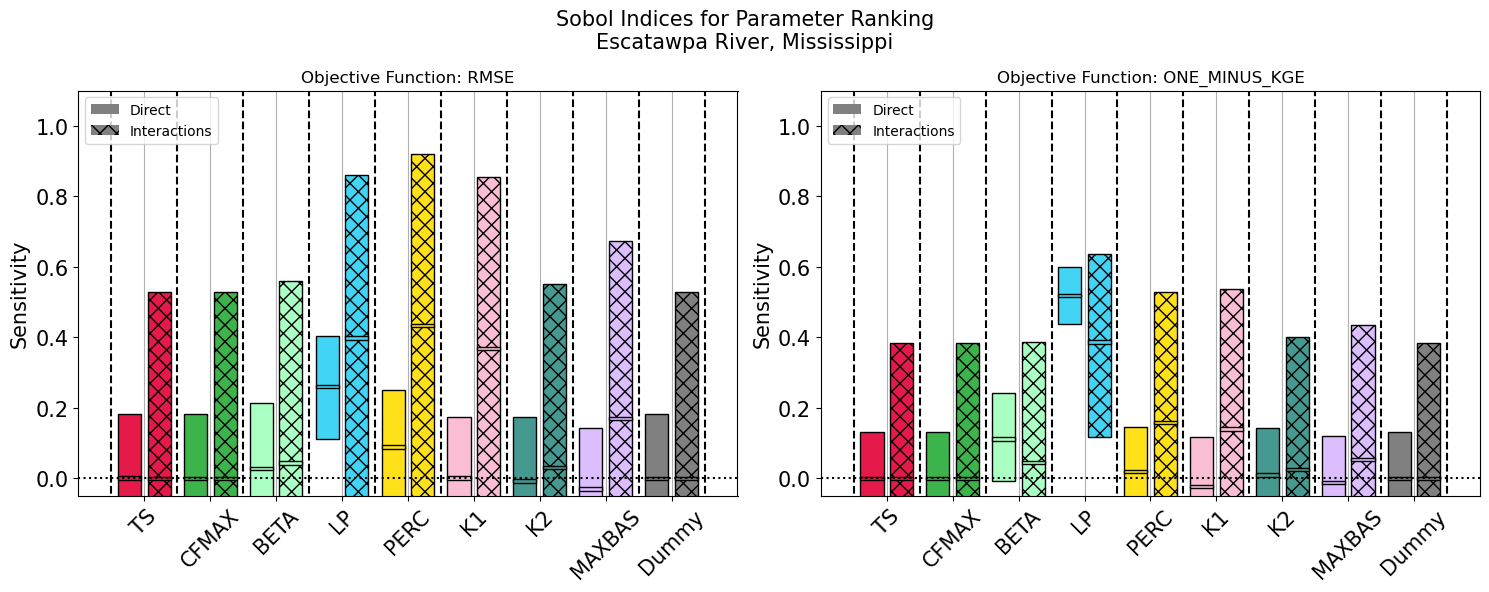

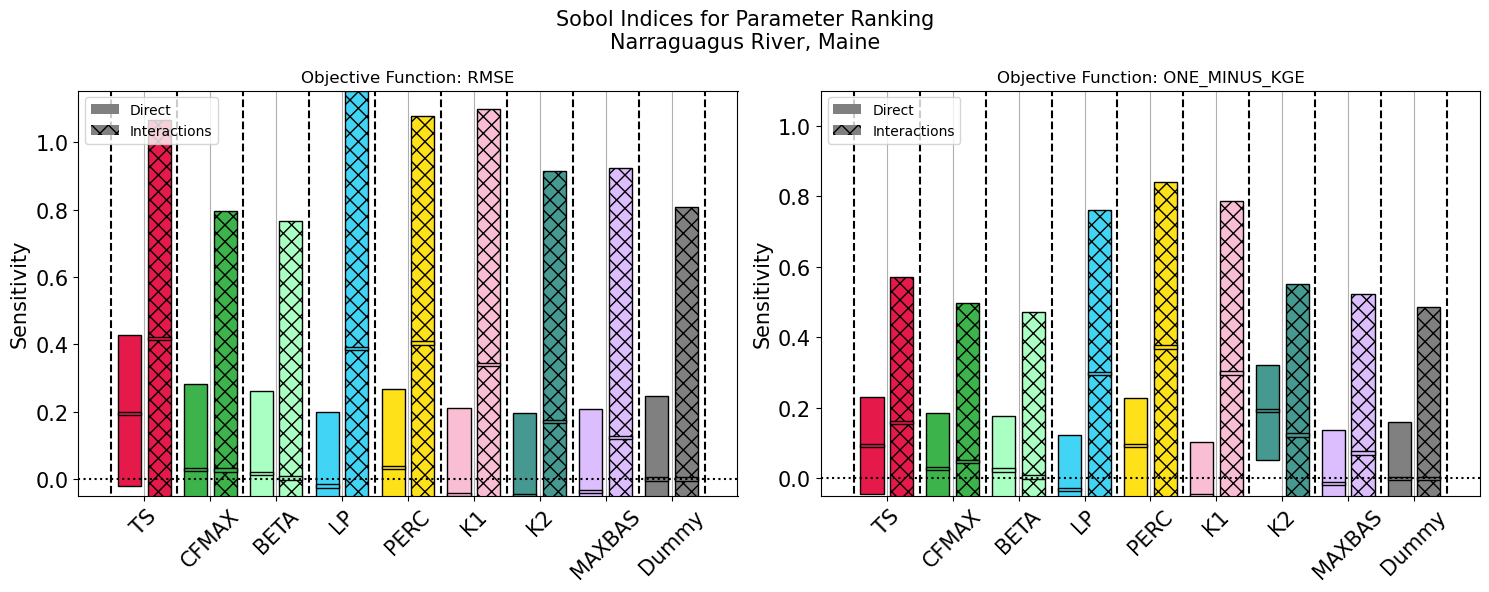

In [18]:
for i, df in enumerate(dfs):

    fig, axs = plt.subplots(1, len(OBJECTIVE_FUNCTIONS), figsize=(15, 6))
    fig.suptitle(f"Sobol Indices for Parameter Ranking\n" + catchment_names[i], fontsize=15)

    for j, of in enumerate(OBJECTIVE_FUNCTIONS):

        # calculate Sobol indices
        S, ST, S_dummy, ST_dummy = VBSA.vbsa_indices(objectives_sobol[i, j, :n_samples], objectives_sobol[i, j, n_samples:(2 * n_samples)], objectives_sobol[i, j, (2 * n_samples):], M=len(SELECTED_PARAMETERS), Nboot=500, dummy=True)

        # calculate mean and confidence interval around mean for Sobol indices
        S  = np.concatenate([S,  np.expand_dims( S_dummy, axis=-1)], axis=1)
        ST = np.concatenate([ST, np.expand_dims(ST_dummy, axis=-1)], axis=1)
        SI = ST - S
        S  = np.array(util.aggregate_boot(S))
        ST = np.array(util.aggregate_boot(ST))
        SI = np.array(util.aggregate_boot(SI))

        # subtract the dummy variable
        S_mean,   S_lower,   S_upper =  S -  S[0, -1]
        SI_mean, SI_lower, SI_upper  = SI - SI[0, -1]

        # plot the Sobol sensitivity indices
        param_names_with_dummy = SELECTED_PARAMETERS + ["Dummy"]
        plt.sca(axs[j])
        plot_functions.boxplot2(np.array([S_mean, SI_mean]), S_lb=np.array([S_lower, SI_lower]), S_ub=np.array([S_upper, SI_upper]), X_Labels=param_names_with_dummy)
        plt.title("Objective Function: " + of.__name__.upper())
        plt.legend([Patch(facecolor="gray"), Patch(facecolor="gray", hatch="xx")], ["Direct", "Interactions"], loc="upper left")
        plt.ylim([-0.05, plt.ylim()[1]])
        plt.gca().xaxis.set_tick_params(rotation=45)

        # fix the colors of the plot (this is sadly not supported by the plotting function)
        for l, box in enumerate([child for child in axs[j]._children if isinstance(child, Rectangle)]):
            param = param_names_with_dummy[l // 4]
            color = plt.cm.jet(None)[param_names.tolist().index(param)] if param in param_names else "gray"
            box.set(facecolor=color, hatch='xx' if l % 4 == 1 else "")

    plt.tight_layout()
    plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task IV: Parameter Ranking</h4>
    <p>Above you find the direct and total Sobol indices for the two catchments and objective functions. We have included a dummy variable, i.e. a random parameter that has no effect on the outcome of a HBV run.</p>
    Please discuss the following questions:
    <ol>
        <li>What is the benefit of the dummy variable and how would you interpret it?</li>
        <li>How would you rank the parameter importance for the different catchments and objective functions?</li>
        <li>Are there any differences between catchments or objective functions? Why could they arise?</li>
        <li>How certain are you about your ranking?</li>
    </ol>
</div>

_DOUBLE CLICK TO ANSWER HERE_

---
## 5 Model Calibration

We now continue with the best performing parameters sets from the Sobol analysis for each catchment and sample and treat these as our calibrated model.

Below you will find the hydrographs of the calibrated model runs compared with the observed runoff and the flow duration curves. Furthermore, we will take a look at the parameter values that lead to the best performing solutions.

### 5.1 Visual Model Inspection

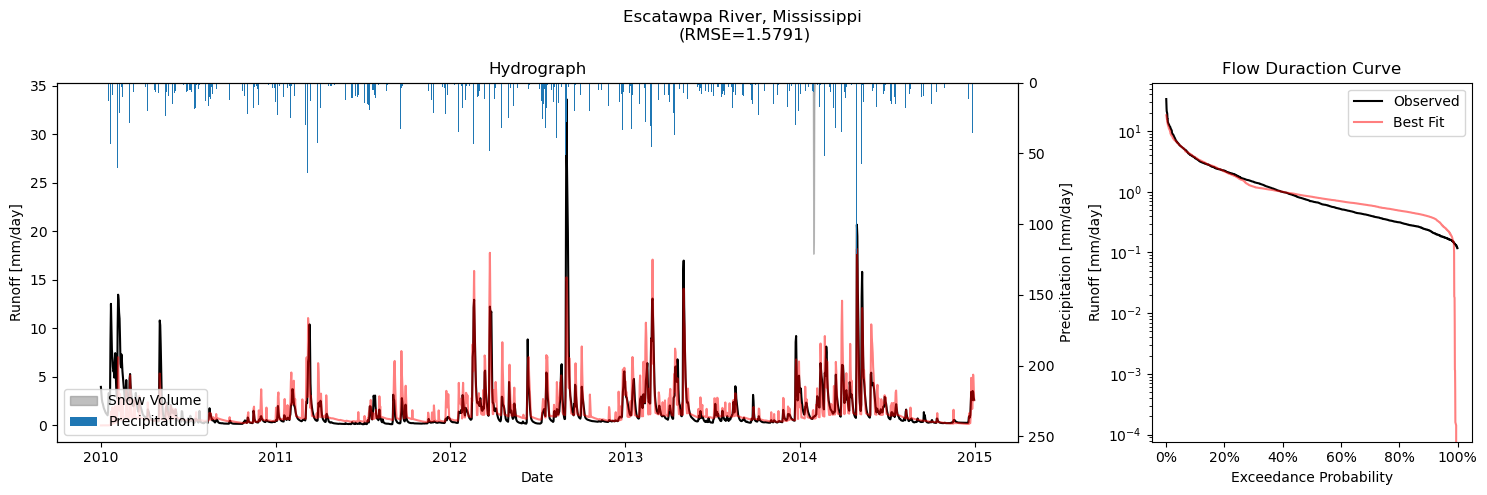

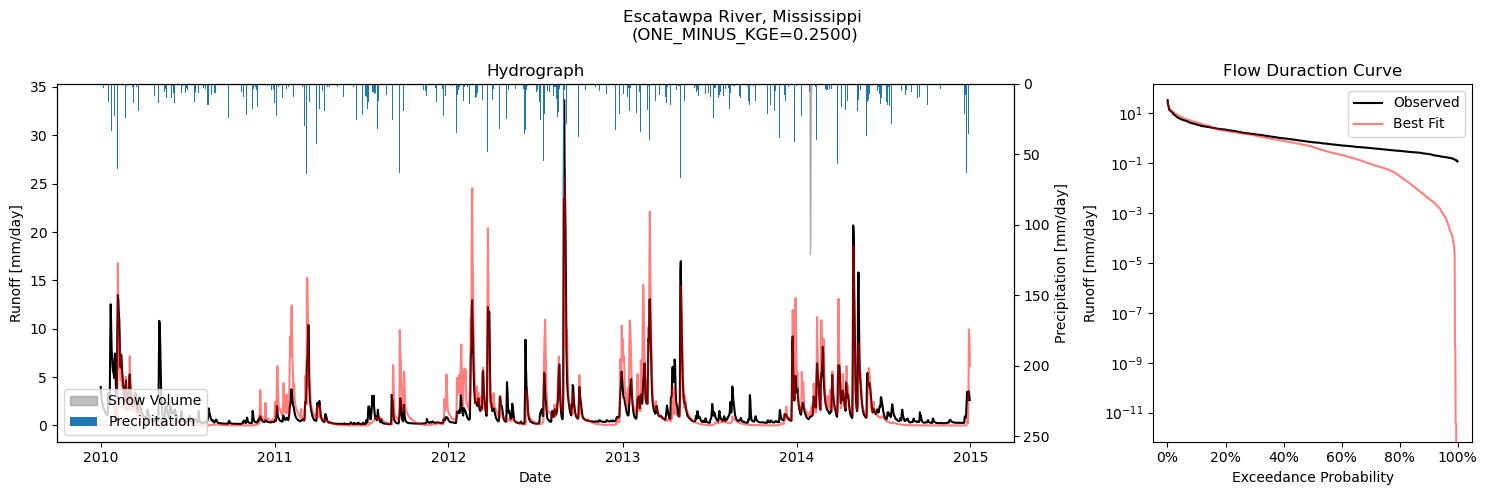

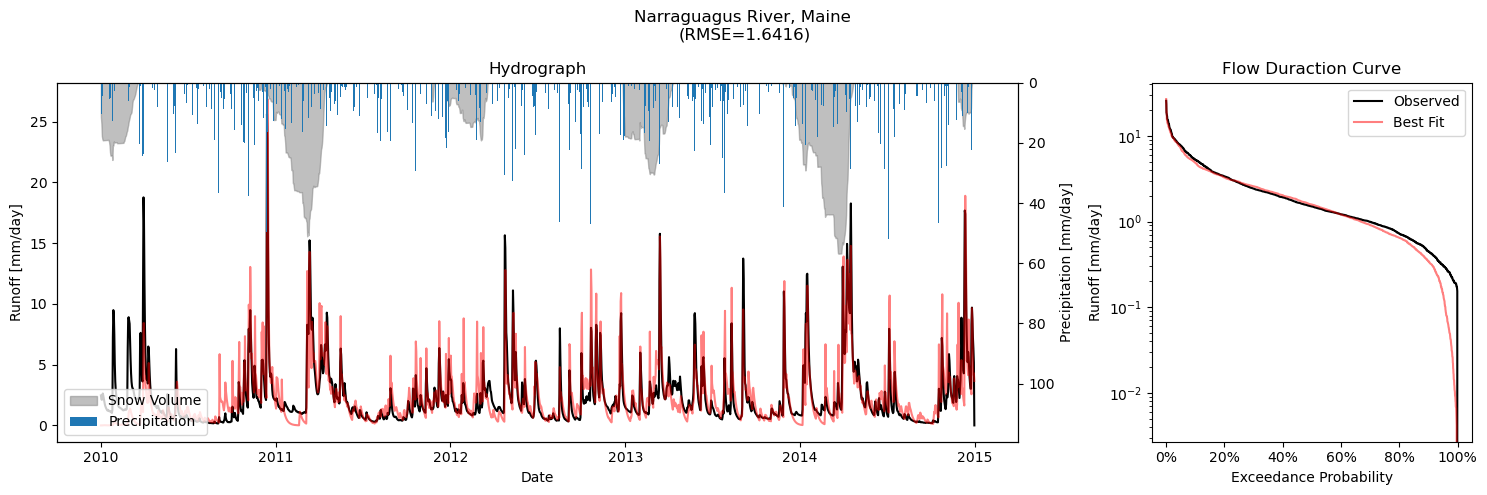

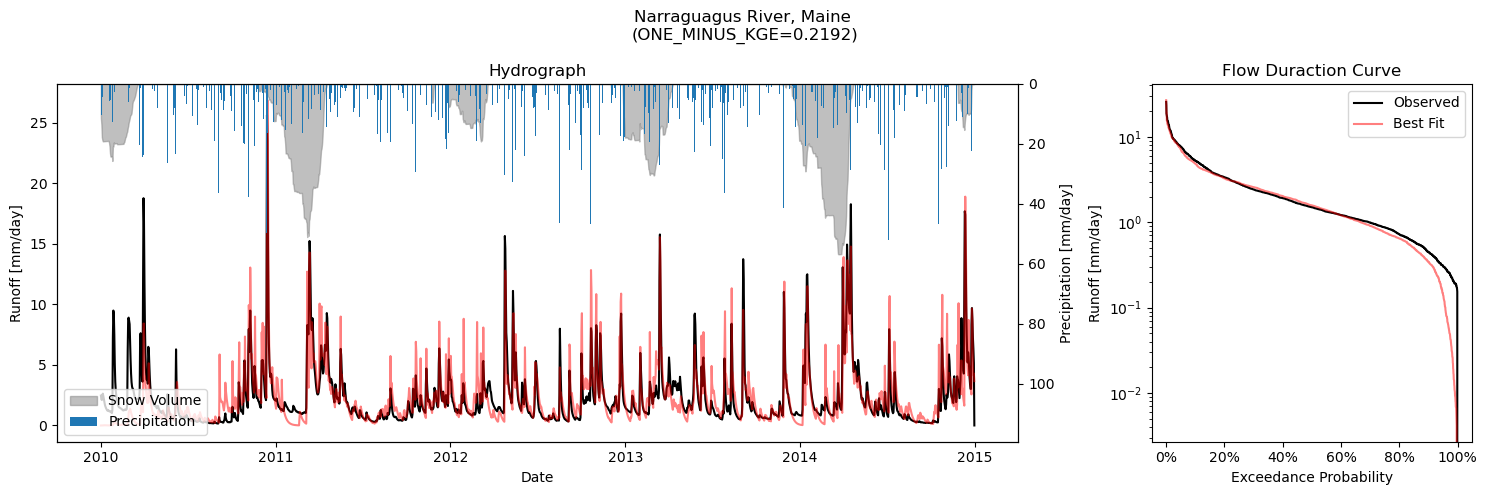

In [21]:
for i, df in enumerate(dfs):
    for j, of in enumerate(OBJECTIVE_FUNCTIONS):

        # grab the best performing parameters set so far
        idxbest = np.argmin(objectives_sobol[i, j])
        params  = samples_sobol[idxbest]

        # use the optimized parameters as the model calibration
        Q_obs = df["Q_obs"]
        Q_opt = run_hbv(df, params)

        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw=dict(width_ratios=[3, 1]))
        fig.suptitle(f"{catchment_names[i]} \n({of.__name__.upper()}={of(Q_obs, Q_opt):.4f})")

        plt.sca(ax0)
        plt.title("Hydrograph")
        plt.plot(df.index, Q_opt, color="red", alpha=0.5, zorder=np.inf, label="Calibrated")
        plot_hydrograph(df)
        plt.legend()

        plt.sca(ax1)
        plt.title("Flow Duraction Curve")
        plot_flow_duration_curve(Q_obs, color="black", label="Observed")
        plot_flow_duration_curve(Q_opt, color="red", alpha=0.5, label="Best Fit")
        plt.legend()

        plt.tight_layout()
        plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task V: Visually Inspecting the Fit</h4>
    <p>In the plots above you will find the best performing model run from the Sobol samples. The blue (precipitation) and gray (snow volume) curves represent water input into the catchment. The red line is the optimized HBV run for this catchment and objective function.</p>
    Please discuss the following questions:
    <ol>
        <li>Would you say that the model fit is good or poor? Why?</li>
        <li>Can you spot differences between catchments and objective functions? Why could they arise?</li>
    </ol>
</div>

_DOUBLE CLICK TO ANSWER HERE_

### 5.2 Parallel Coordinate Plots

In [ ]:
n_best = 50

for j, of in enumerate(OBJECTIVE_FUNCTIONS):

    fig, axs = plt.subplots(1, len(SELECTED_PARAMETERS), figsize=(10, 6))
    fig.suptitle(f"{n_best} Best Parameter Sets using " + of.__name__.upper())

    for i, df in enumerate(dfs):

        # go through the n_best best parameter sets
        for k, idxbest in enumerate(np.argsort(objectives_sobol[i, j])[:n_best]):
            params = samples_sobol[idxbest, np.isin(param_names, SELECTED_PARAMETERS)]

            for l in range(len(params) - 1):
                axs[l].add_artist(plt.matplotlib.patches.ConnectionPatch(xyA=(0, params[l]), xyB=(0, params[l + 1]), coordsA="data", coordsB="data", axesA=axs[l], axesB=axs[l + 1], color=f"C{3*i}", alpha=1/(k + 1)**0.5, zorder=-np.inf))

    for ax, param_name, bound in zip(axs, SELECTED_PARAMETERS, ranges[np.isin(param_names, SELECTED_PARAMETERS)]):
        plt.sca(ax)
        [ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom"]]
        plt.title(param_name, x=0.05, y=0.95, ha="left")
        plt.xticks([], [])
        plt.ylim(bound)

    fig.legend([plt.matplotlib.patches.Patch(color=color) for color in ("C0", "C3")], catchment_names, ncols=2, loc="upper center", bbox_to_anchor=(0.5, 0.95))
    plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task VI: Parallel Coordinate Plots</h4>
    <p>The above plots are called parallel coordiante plots. Each axis represents the possible range of one of the parameters you selected for the Sobol analysis. The two plots are for the two objective functions respectively. The colored lines represent the <code>n_best</code> parameter sets from the sobol analyis. Their opacity scales with their goodness of fit (the best being the most opaque). Parallel coordinate plots are used to discuss the differences between optimal parameter sets for different model setups, i.e. in this case catchments and objective functions.</p>
    Please discuss the following questions:
    <ol>
        <li>Do different objective functions result in similar optimal parameters sets for each catchment? Compare the same color between plots.</li>
        <li>Are there differences between catchments? Compare the colors in one plot.</li>
        <li>How do the parallel coordiante plots relate to the Sobol sensitivity indices?</li>
    </ol>
</div>

_DOUBLE CLICK TO ANSWER HERE_

---

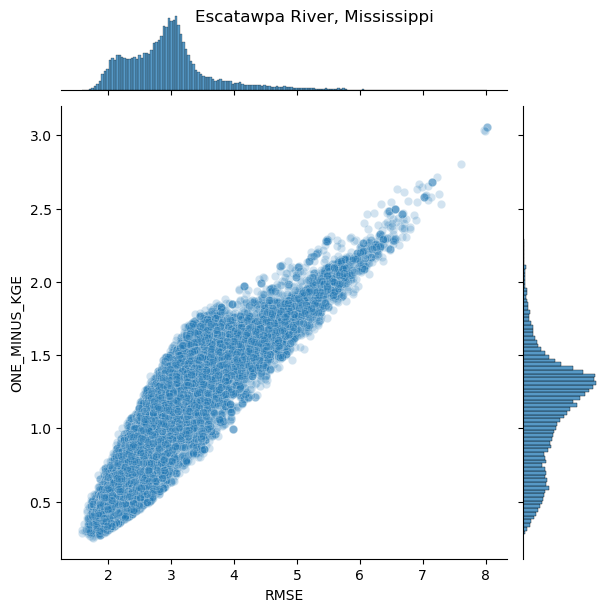

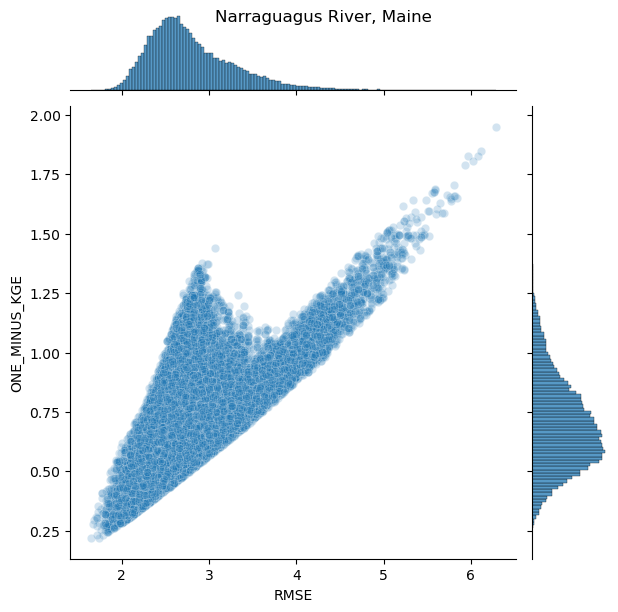

In [30]:
import seaborn as sns

for i, df in enumerate(dfs):

    sns.jointplot(x=objectives_sobol[i, 0], y=objectives_sobol[i, 1], alpha=0.2)
    plt.xlabel(OBJECTIVE_FUNCTIONS[0].__name__.upper())
    plt.ylabel(OBJECTIVE_FUNCTIONS[1].__name__.upper())
    plt.gcf().suptitle(catchment_names[i])
    plt.show()